## TODO:
* HierQ 
 - Relative goal-space encoding HierQ.
 - Option for Goal-Conditioned Top-level Policy.
 - Option for masking illegal states in table.

 
* Planning/ Search
 - Basic MCTS procedure logic
 - Exploration count matrix for all states.
 - UCT formula for goal-directed exploration.

# HierQ(n)

 - n-step Tree Backup learning rule

In [1]:
# Reload dependencies upon changes
%load_ext autoreload
%autoreload 2

#### Libraries

In [2]:
from functools import partial
import typing
import sys

import numpy as np
import gym
import tqdm
import matplotlib.pyplot as plt

from mazelab_experimenter import EnvRegister
from mazelab_experimenter import AgentShelve
from mazelab_experimenter import evaluate, GenericOuterHook, benchmark
from mazelab_experimenter.utils import find

In [3]:
AgentShelve.get_types()

['TabularQLearner',
 'TabularQLearnerN',
 'TabularQLambda',
 'TabularQET',
 'TabularDynaQ',
 'MonteCarloQLearner',
 'RandomAgent',
 'HierQ',
 'HierQV2',
 'HierQTD',
 'HierQTS',
 'HierQET']

In [4]:
AgentShelve.get_keyword_args('HierQV2')

<Signature (observation_shape: Tuple, n_actions: int, n_levels: int, horizons: List[int], lr: float = 0.5, epsilon: float = 0.1, discount: float = 0.95, relative_goals: bool = True, universal_top: bool = True, ignore_training_time: bool = False, legal_states: numpy.ndarray = None) -> None>

In [5]:
t = 100

name_four_rooms = EnvRegister.register(
    maze_type='four_rooms_HierQ', 
    name=f'four_rooms_hierq-v0', 
    env_args=dict(
        shortest_path_rewards=True
    ),
    generator_args=dict(),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[3, 8]]
    ),
    time_limit=t,
    override=True
)

name_gridworld = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld_hierq-v0', 
    env_args=dict(
        shortest_path_rewards=True
    ),
    generator_args=dict(height=12, width=12),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[10, 10]]
    ),
    time_limit=t,
    override=True
)

Warning, room_size and gap_size are best kept as uniformly odd or even, not one odd one even.


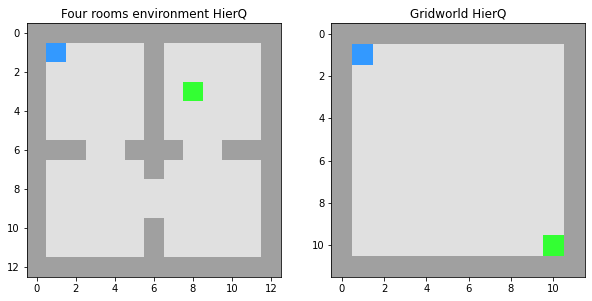

In [6]:
# Instantiate the registered MazeLab environment as a Gym environment.
four_rooms = gym.make(name_four_rooms)
gridworld = gym.make(name_gridworld)

# Illustrate the randomly generated maze. 
_ = four_rooms.reset(), gridworld.reset()

img_a, img_b = four_rooms.unwrapped.get_image(), gridworld.unwrapped.get_image()

four_rooms.close()
gridworld.close()

f, axarr = plt.subplots(1, 2, figsize=(10, 5))

axarr[0].imshow(img_a)
axarr[0].set_title("Four rooms environment HierQ")

axarr[1].imshow(img_b)
axarr[1].set_title("Gridworld HierQ")

plt.show()

In [93]:
def gen_hierq(n_levels: int, horizon: int, _env: gym.Env, n_tb: int, lr: float = 0.8, discount: float = 0.997, epsilon: float = 0.1):
    # Helper function for instantiating a HierQ agent with a fixed environment goal.
    agent = AgentShelve.retrieve(
        agent='HierQET',
        keyword_arguments=dict(
            observation_shape=_env.observation_space.shape,
            n_actions=_env.action_space.n,
            n_levels=n_levels,
            horizons=[horizon] * (n_levels - 1) + [200],
            lr=lr, discount=discount, epsilon=epsilon, n_tb=n_tb
        ))
    agent.set_goal(agent._get_index(_env.unwrapped.maze.get_end_pos()[0]))
    return agent


def get_agent_gen(_env_name: str):
    # Wrapper function for instantiating the agent generator with an environment dependency.
    dummy = gym.make(_env_name)
    return [
        lambda: n1_l2(_env=dummy),
        lambda: n2_l2(_env=dummy),
        lambda: n3_l2(_env=dummy),
#         lambda: n1_l3(_env=dummy),
#         lambda: n2_l3(_env=dummy),
#         lambda: n3_l3(_env=dummy)
    ]

n1_l2 = partial(gen_hierq, n_levels=2, horizon=3, n_tb=1)
n2_l2 = partial(gen_hierq, n_levels=2, horizon=3, n_tb=2)
n3_l2 = partial(gen_hierq, n_levels=2, horizon=3, n_tb=3)

n1_l3 = partial(gen_hierq, n_levels=3, horizon=3, n_tb=1)
n2_l3 = partial(gen_hierq, n_levels=3, horizon=3, n_tb=2)
n3_l3 = partial(gen_hierq, n_levels=3, horizon=3, n_tb=3)

In [21]:
# Benchmark configuration
r = 10
it = 200
eps = 1
trials = 10
verbose = True

# Benchmark data for each agent.
benchmark_data = list()
for env_name in [name_four_rooms, name_gridworld]:
    
    env_data = list()
    for agent_gen in get_agent_gen(env_name):
        # Run the benchmark
        env_data.append(
            benchmark(
                env_id=env_name, 
                _agent_gen=agent_gen, 
                agent_test_kwargs=dict(behaviour_policy=False),
                agent_train_kwargs=dict(),
                num_repetitions=r,
                num_iterations=it,
                num_episodes=eps,
                num_trials=trials,
                evaluation_hooks=[GenericOuterHook()],
                verbose=verbose,
                asynchronous=False
            )
        )
    benchmark_data.append((env_name, env_data))

-- Benchmarking Repetition 1 / 10 --- ETA:  --- Rate: 0 sec/ it
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 200/200 [00:15<00:00, 12.69it/s]
-- Benchmarking Repetition 2 / 10 --- ETA: 0:02:23 --- Rate: 15 sec/ it
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 11.78it/s]
-- Benchmarking Repetition 3 / 10 --- ETA: 0:02:12 --- Rate: 16 sec/ it
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 200/200 [00:15<00:00, 12.92it/s]
-- Benchmarking Repetition 4 / 10 --- ETA: 0:01:53 --- Rate: 16 sec/ it
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 200/200 [00:15<00:00, 12.95it/s]
-- Benchmarking Repetition 5 / 10 --- ETA: 0:01:36 --- Rate: 16 sec/ it
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 200/200 [00:13<00:00, 14.37it/s]
-- Benchmarking Repetition 6 / 10 --- ETA: 0:01:

## Plot Results

In [22]:
def plot_progress(arr: np.ndarray, population_size: int, axis: int = 0, label: str = None, style: str = "-") -> None:
    # Helper function for plotting.
    mean_length = arr[...,axis][...,0].mean(axis=0)
    std_length = arr[...,axis][...,0].std(axis=0) / np.sqrt(population_size)

    plt.plot(mean_length, label=label, linewidth=2)
    plt.fill_between(np.arange(len(mean_length)), mean_length + std_length, mean_length - std_length, alpha=0.1)
    
    
def manhattan_dist(c_a: np.ndarray, c_b: np.ndarray):
    # Helper function to compute the L1 distance between two arrays.
    return np.sum(np.abs(np.asarray(c_a) - np.asarray(c_b)))

#### Four-Rooms

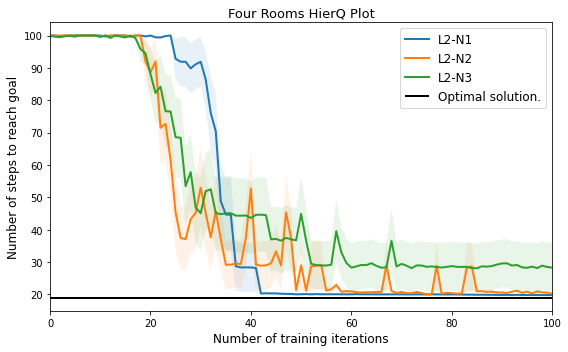

In [23]:
plt.figure(figsize=(8, 5))

for a, l, s in zip(benchmark_data[0][1], ['L2-N1', 'L2-N2', 'L2-N3', 'L3-N1', 'L3-N2', 'L3-N3'], ['-'] * 3 + ['--'] * 3):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l, style=s)

# Optimal solution on this example is 14 steps.
plt.hlines(19, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 100])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

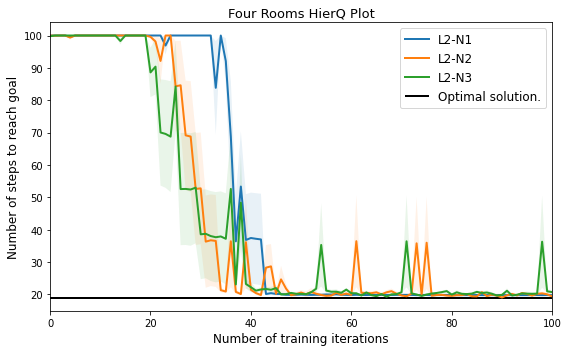

In [19]:
plt.figure(figsize=(8, 5))

for a, l, s in zip(benchmark_data[0][1], ['L2-N1', 'L2-N2', 'L2-N3', 'L3-N1', 'L3-N2', 'L3-N3'], ['-'] * 3 + ['--'] * 3):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l, style=s)

# Optimal solution on this example is 14 steps.
plt.hlines(19, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 100])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

#### GridWorld

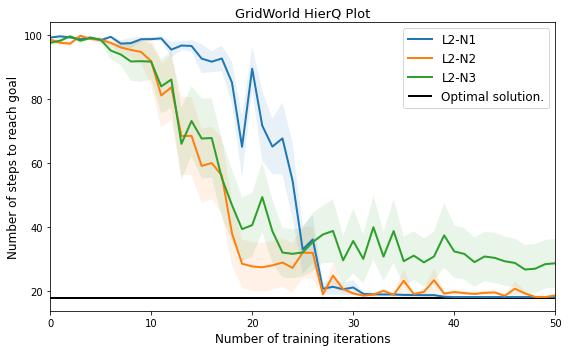

In [24]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], ['L2-N1', 'L2-N2', 'L2-N3', 'L3-N1', 'L3-N2', 'L3-N3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(gridworld.unwrapped.maze.get_start_pos(), gridworld.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 50, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 50])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], ['L2-N1', 'L2-N2', 'L2-N3', 'L3-N1', 'L3-N2', 'L3-N3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(gridworld.unwrapped.maze.get_start_pos(), gridworld.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 50, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 50])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Large Env

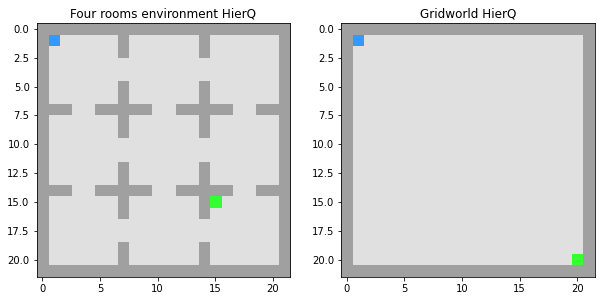

In [39]:
t = 500

name_four_rooms = EnvRegister.register(
    maze_type='n_rooms_square', 
    name=f'four_rooms-v1', 
    env_args=dict(
        shortest_path_rewards=True
    ),
    generator_args=dict(num_rooms=9, room_size=6, gap_size=2),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[15, 15]]
    ),
    time_limit=t,
    override=True
)

name_gridworld = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld-v1', 
    env_args=dict(
        shortest_path_rewards=True
    ),
    generator_args=dict(height=22, width=22),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[20, 20]]
    ),
    time_limit=t,
    override=True
)

# Instantiate the registered MazeLab environment as a Gym environment.
four_rooms = gym.make(name_four_rooms)
gridworld = gym.make(name_gridworld)

# Illustrate the randomly generated maze. 
_ = four_rooms.reset(), gridworld.reset()

img_a, img_b = four_rooms.unwrapped.get_image(), gridworld.unwrapped.get_image()

four_rooms.close()
gridworld.close()

f, axarr = plt.subplots(1, 2, figsize=(10, 5))

axarr[0].imshow(img_a)
axarr[0].set_title("Four rooms environment HierQ")

axarr[1].imshow(img_b)
axarr[1].set_title("Gridworld HierQ")

plt.show()

In [94]:
def gen_hierq(n_levels: int, horizon: int, _env: gym.Env, n_tb: int, lr: float = 0.8, discount: float = 0.997, epsilon: float = 0.1):
    # Helper function for instantiating a HierQ agent with a fixed environment goal.
    agent = AgentShelve.retrieve(
        agent='HierQET',
        keyword_arguments=dict(
            observation_shape=_env.observation_space.shape,
            n_actions=_env.action_space.n,
            n_levels=n_levels,
            horizons=[horizon] * (n_levels - 1) + [200],
            lr=lr, discount=discount, epsilon=epsilon, n_tb=n_tb
        ))
    agent.set_goal(agent._get_index(_env.unwrapped.maze.get_end_pos()[0]))
    return agent


def get_agent_gen(_env_name: str):
    # Wrapper function for instantiating the agent generator with an environment dependency.
    dummy = gym.make(_env_name)
    return [
        lambda: n1_l2(_env=dummy),
        lambda: n2_l2(_env=dummy),
        lambda: n3_l2(_env=dummy),
#         lambda: n1_l3(_env=dummy),
#         lambda: n2_l3(_env=dummy),
#         lambda: n3_l3(_env=dummy)
    ]

n1_l2 = partial(gen_hierq, n_levels=2, horizon=3, n_tb=1)
n2_l2 = partial(gen_hierq, n_levels=2, horizon=3, n_tb=2)
n3_l2 = partial(gen_hierq, n_levels=2, horizon=3, n_tb=3)

n1_l3 = partial(gen_hierq, n_levels=3, horizon=3, n_tb=1)
n2_l3 = partial(gen_hierq, n_levels=3, horizon=3, n_tb=2)
n3_l3 = partial(gen_hierq, n_levels=3, horizon=3, n_tb=3)

In [41]:
# Benchmark configuration
r = 10
it = 300
eps = 1
trials = 10
verbose = True

# Benchmark data for each agent.
benchmark_data = list()
for env_name in [name_four_rooms, name_gridworld]:
    
    env_data = list()
    for agent_gen in get_agent_gen(env_name):
        # Run the benchmark
        env_data.append(
            benchmark(
                env_id=env_name, 
                _agent_gen=agent_gen, 
                agent_test_kwargs=dict(behaviour_policy=False),
                agent_train_kwargs=dict(),
                num_repetitions=r,
                num_iterations=it,
                num_episodes=eps,
                num_trials=trials,
                evaluation_hooks=[GenericOuterHook()],
                verbose=verbose,
                asynchronous=False
            )
        )
    benchmark_data.append((env_name, env_data))

-- Benchmarking Repetition 1 / 10 --- ETA:  --- Rate: 0 sec/ it
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 300/300 [01:13<00:00,  4.06it/s]
-- Benchmarking Repetition 2 / 10 --- ETA: 0:11:14 --- Rate: 74 sec/ it
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 300/300 [01:07<00:00,  4.46it/s]
-- Benchmarking Repetition 3 / 10 --- ETA: 0:09:33 --- Rate: 71 sec/ it
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 300/300 [01:15<00:00,  4.00it/s]
-- Benchmarking Repetition 4 / 10 --- ETA: 0:08:32 --- Rate: 73 sec/ it
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 300/300 [01:01<00:00,  4.88it/s]
-- Benchmarking Repetition 5 / 10 --- ETA: 0:07:03 --- Rate: 70 sec/ it
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 300/300 [01:01<00:00,  4.90it/s]
-- Benchmarking Repetition 6 / 10 --- ETA: 0:05:

## Plot Results

In [42]:
def plot_progress(arr: np.ndarray, population_size: int, axis: int = 0, label: str = None, style: str = "-") -> None:
    # Helper function for plotting.
    mean_length = arr[...,axis][...,0].mean(axis=0)
    std_length = arr[...,axis][...,0].std(axis=0) / np.sqrt(population_size)

    plt.plot(mean_length, label=label, linewidth=2)
    plt.fill_between(np.arange(len(mean_length)), mean_length + std_length, mean_length - std_length, alpha=0.1)
    
    
def manhattan_dist(c_a: np.ndarray, c_b: np.ndarray):
    # Helper function to compute the L1 distance between two arrays.
    return np.sum(np.abs(np.asarray(c_a) - np.asarray(c_b)))

#### Four-Rooms

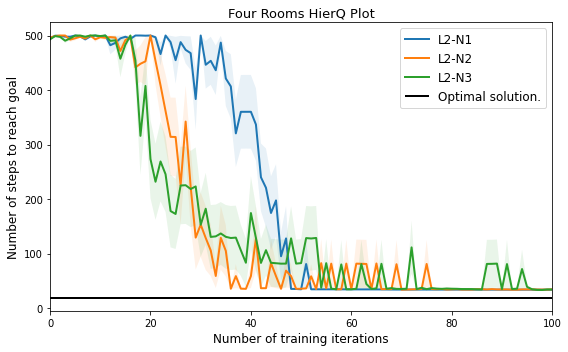

In [45]:
plt.figure(figsize=(8, 5))

for a, l, s in zip(benchmark_data[0][1], ['L2-N1', 'L2-N2', 'L2-N3', 'L3-N1', 'L3-N2', 'L3-N3'], ['-'] * 3 + ['--'] * 3):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l, style=s)

# Optimal solution on this example is 14 steps.
plt.hlines(19, 0, it, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 100])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

#### GridWorld

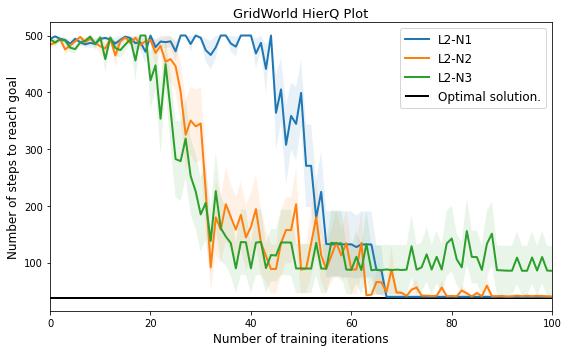

In [46]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], ['L2-N1', 'L2-N2', 'L2-N3', 'L3-N1', 'L3-N2', 'L3-N3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(gridworld.unwrapped.maze.get_start_pos(), gridworld.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, it, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 100])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

## Backup Plots

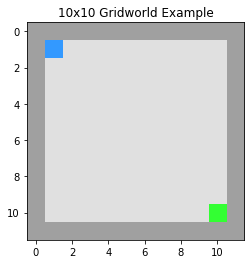

In [206]:
name_gridworld = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld-v0', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(height=12, width=12),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[10, 10]]
    ),
    time_limit=1000,
    override=True
)
gridworld = gym.make(name_gridworld)

# Illustrate the randomly generated maze. 
_ = gridworld.reset()

img_a = gridworld.unwrapped.get_image()
gridworld.close()

plt.imshow(img_a)
plt.title("10x10 Gridworld Example")

plt.show()

In [219]:
def extract_value(table):
    return table.max(axis=-1).reshape(agent.observation_shape)[1:-1, 1:-1]

In [230]:
# Initialize our agent with the environment dimensions.
agent = n1_l2(_env=gridworld, lr=1, discount=0.9, epsilon=0.25)

q_tables = list()
atomics = list()
for it in [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 90, 900]:
    agent.train(gridworld, it, True)
    q_tables.append(np.copy(agent.critics[-1].table))
    atomics.append(np.copy(agent.critics[0].table[:,130,:]))

HierQ(n) Training: 0it [00:00, ?it/s]
HierQ(n) Training: 100%|█████████████████████████████████████████████████████████████| 900/900 [00:10<00:00, 86.08it/s]


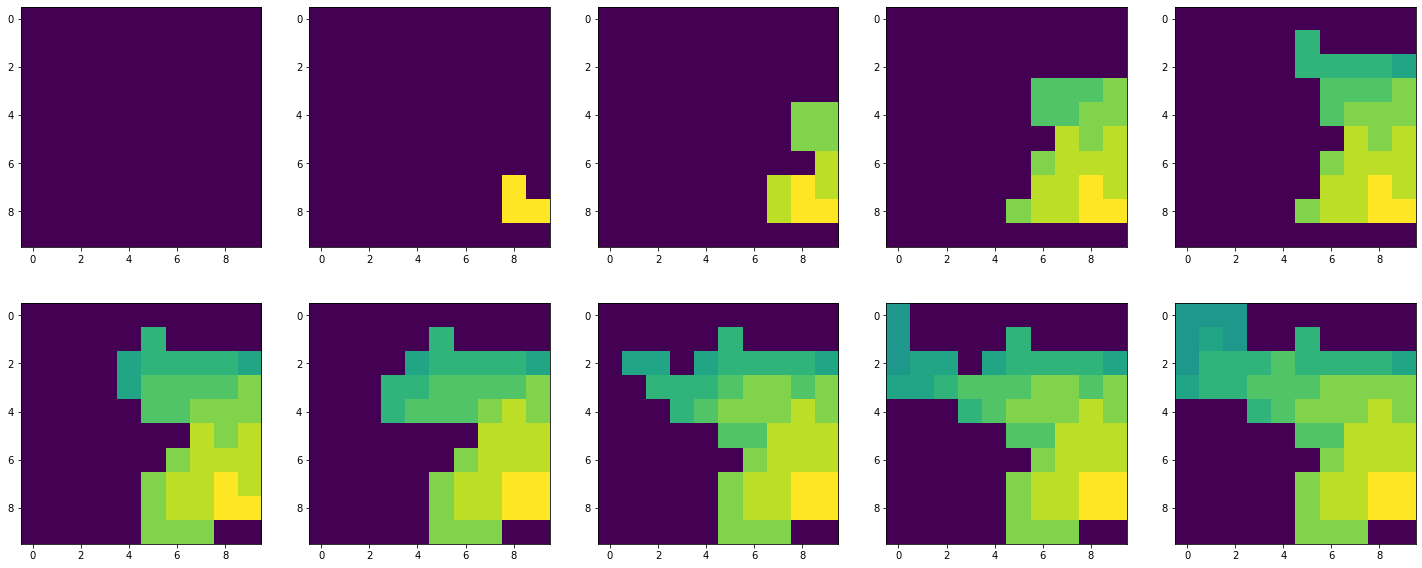

In [231]:
fig, axs = plt.subplots(2, 5, figsize=(25, 10))

for i, tab in enumerate(q_tables[1:11]):
    axs[i // 5, i % 5].imshow(extract_value(tab[:,0,:]))

plt.show()

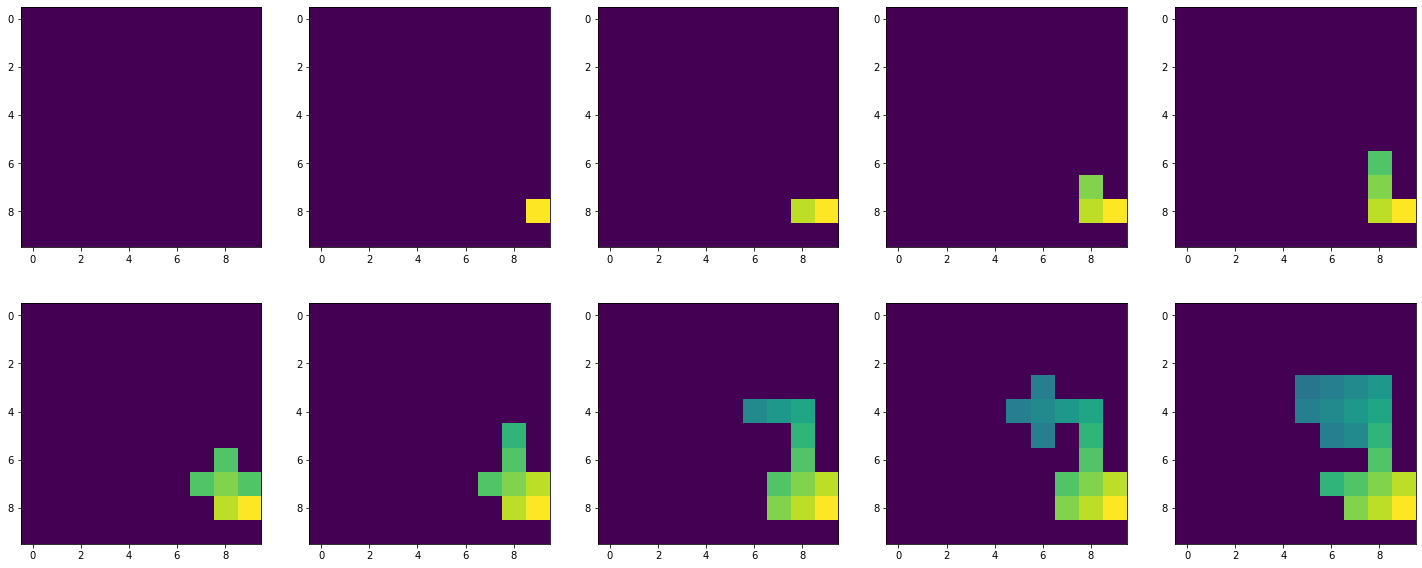

In [232]:
fig, axs = plt.subplots(2, 5, figsize=(25, 10))

for i, tab in enumerate(atomics[1:11]):
    axs[i // 5, i % 5].imshow(extract_value(tab))

plt.show()

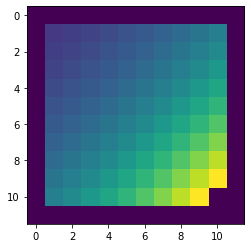

In [233]:
plt.imshow(agent.critics[0].table[:,130,:].max(axis=-1).reshape(agent.observation_shape))

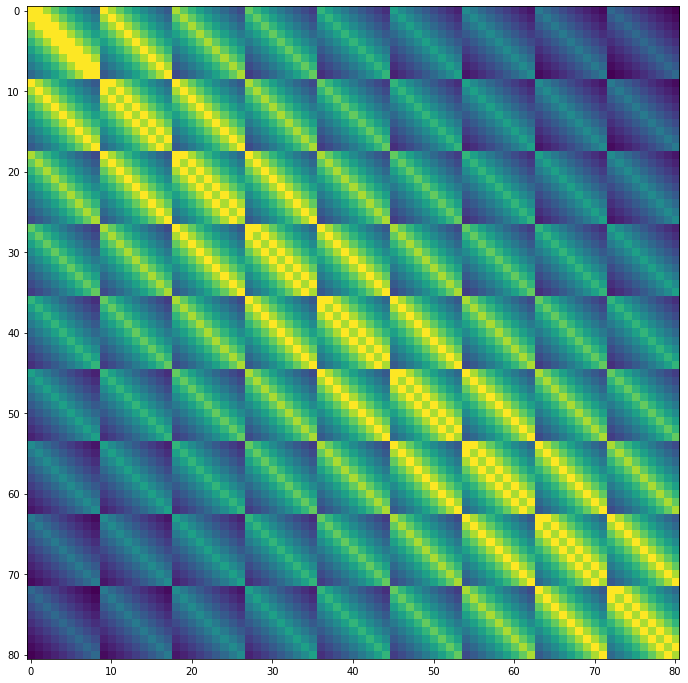

In [234]:
plt.figure(figsize=(12, 12))
plt.imshow(agent.critics[0].table.max(axis=-1).reshape((*agent.observation_shape, *agent.observation_shape))[1:-2, 1:-2, 1:-2, 1:-2].reshape((9**2, 9**2)))

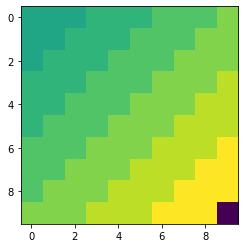

In [235]:
tab = extract_value(q_tables[12])
plt.imshow(tab)

In [180]:
tab

array([[0.59049, 0.59049, 0.59049, 0.6561 , 0.6561 , 0.6561 , 0.729  ,
        0.729  , 0.729  ],
       [0.59049, 0.59049, 0.6561 , 0.6561 , 0.6561 , 0.729  , 0.729  ,
        0.729  , 0.81   ],
       [0.59049, 0.6561 , 0.6561 , 0.6561 , 0.729  , 0.729  , 0.729  ,
        0.81   , 0.81   ],
       [0.6561 , 0.6561 , 0.6561 , 0.729  , 0.729  , 0.729  , 0.81   ,
        0.81   , 0.81   ],
       [0.6561 , 0.6561 , 0.729  , 0.729  , 0.729  , 0.81   , 0.81   ,
        0.81   , 0.9    ],
       [0.6561 , 0.729  , 0.729  , 0.729  , 0.81   , 0.81   , 0.81   ,
        0.9    , 0.9    ],
       [0.729  , 0.729  , 0.729  , 0.81   , 0.81   , 0.81   , 0.9    ,
        0.9    , 0.9    ],
       [0.729  , 0.729  , 0.81   , 0.81   , 0.81   , 0.9    , 0.9    ,
        0.9    , 1.     ],
       [0.729  , 0.81   , 0.81   , 0.81   , 0.9    , 0.9    , 0.9    ,
        1.     , 1.     ]])

In [124]:
tab.min()

-180.34867384318358

In [134]:
x = np.arange(10)
mask = x!=5

x * mask + ~mask

array([0, 1, 2, 3, 4, 1, 6, 7, 8, 9])

# Notes

In [1]:
# Reload dependencies upon changes
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import typing
import sys

import numpy as np
import gym
import tqdm
import matplotlib.pyplot as plt

from mazelab_experimenter import EnvRegister
from mazelab_experimenter import AgentShelve
from mazelab_experimenter import evaluate, GenericOuterHook, benchmark
from mazelab_experimenter.utils import find

In [140]:
name_gridworld = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld_hierq-v0', 
    env_args=dict(
        shortest_path_rewards=True, track_states=True
    ),
    generator_args=dict(height=12, width=12),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[10, 10]]
    ),
    time_limit=100,
    override=True
)

env = gym.make(name_gridworld)


agent = AgentShelve.retrieve(
    agent='HierQET',
    keyword_arguments=dict(
        observation_shape=env.observation_space.shape,
        n_actions=env.action_space.n,
        n_levels=2,
        horizons=[3, 200],
        lr=0.8, discount=0.997, epsilon=0.1
    ))
agent.set_goal(agent._get_index(env.unwrapped.maze.get_end_pos()[0]))

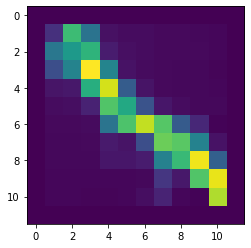

In [117]:
plt.imshow(np.sum(env.unwrapped.state_count_memory, axis=0))

In [118]:
np.zeros((1, len([0]), 1))[0, 0]

array([0.])

In [119]:
env.unwrapped.state_count

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [1]:
sorted( [38, 11, 47, 30, 24, 14, 49, 2, 33, 51, 
31, 18, 28, 16])

[2, 11, 14, 16, 18, 24, 28, 30, 31, 33, 38, 47, 49, 51]